<a href="https://colab.research.google.com/github/MDankloff/Delayed-Fairness-Project/blob/main/BAF_TryOut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import random
import glob
import os
import joblib


In [ ]:
!pip install aequitas #Fairness tree aequitas tool
from aequitas.group import Group # Fairness metrics
from aequitas.bias import Bias
from aequitas.fairness import Fairness

# Load BAF data

Saved parquet files from csv

In [4]:
from google.colab import drive
drive.mount('/content/drive')
!cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF'

Mounted at /content/drive


In [3]:
base_path = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/parquet data'

extension = "parquet" #parquet for smaller files, csv available
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


In [6]:
#Rename datasets
base = dataframes['Base']
variant1 = dataframes['Variant I']
variant2 = dataframes['Variant II']
variant3 = dataframes['Variant III']
variant4 = dataframes['Variant IV']
variant5 = dataframes['Variant V']

#for better display
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

dfs = [base, variant1, variant2, variant3, variant4, variant5]

df = variant4 #set to preferred variant
new_df = df.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

# Explore Data

In [9]:
df['housing_status'].unique()

array(['BC', 'BE', 'BB', 'BA', 'BF', 'BD', 'BG'], dtype=object)

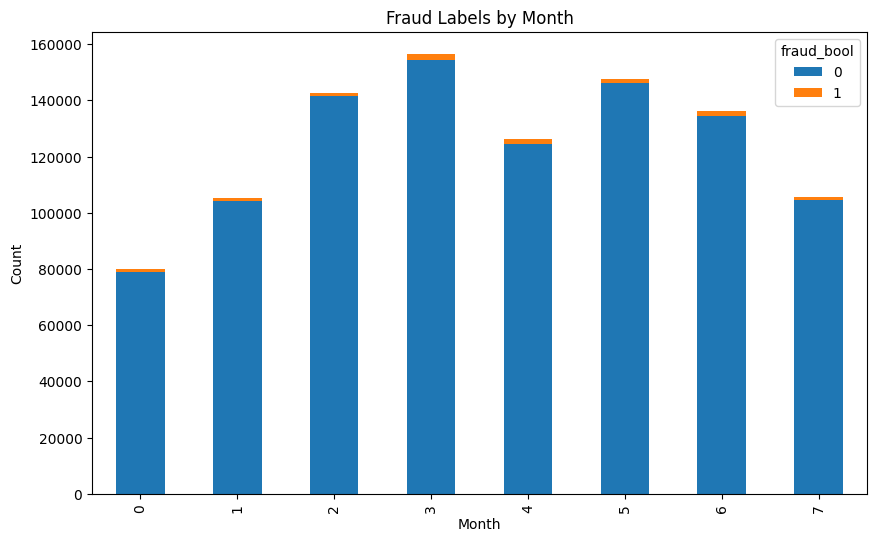

In [13]:
fraud_per_month = df.groupby(['month','fraud_bool']).size().unstack()
fraud_per_month.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Fraud Labels by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

In [14]:
df['month'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

# Create groups per age

In [35]:
  # define age groups - according to BAF authors
df['group'] = np.where(df['customer_age'] >= 50, 'Older', 'Younger')

  # split in 2 groups
group_a = df[df['group'] == 'Younger']
group_b = df[df['group'] == 'Older']

In [36]:
'''Agent A & B characteristics
demographics: customer_age, housing_status, income, employment_status
credit history: credit_risk_score, proposed_credit_limit, intended_balcon_amount
loan application details:  '''

'Agent A & B characteristics \ndemographics: customer_age, housing_status, income, employment_status \ncredit history: credit_risk_score, proposed_credit_limit, intended_balcon_amount\nloan application details:  '

<Axes: xlabel='group'>

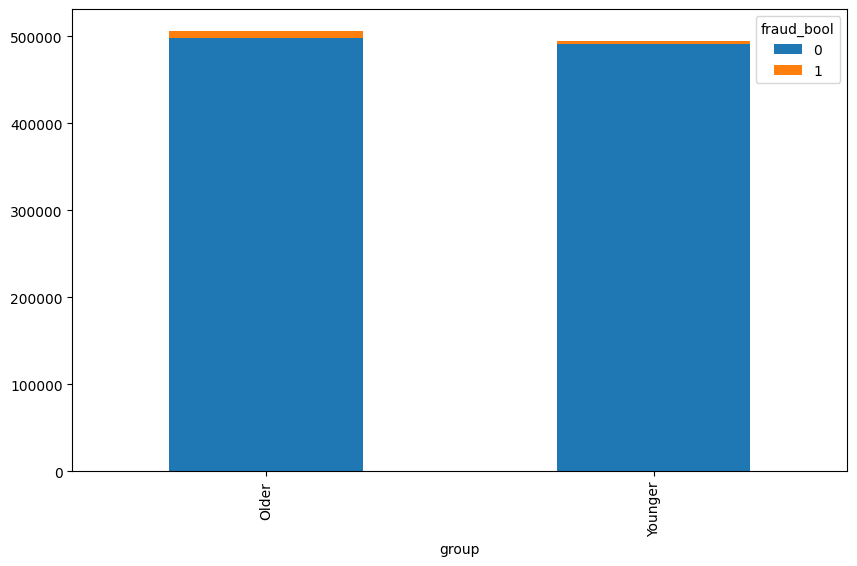

In [38]:
fraud_per_age=df.groupby(['group','fraud_bool']).size().unstack()
fraud_per_age.plot(kind='bar', stacked=True, figsize=(10, 6))

In [40]:
#group_a.count()

In [41]:
group_a[group_a['fraud_bool'] == 1]['fraud_bool'].count()

2656

In [42]:
fraud_prop_groupa = group_a[group_a['fraud_bool'] == 1]['fraud_bool'].count() / group_a['fraud_bool'].count()
print(f"Fraud proportion for group_a: {fraud_prop_groupa}")

Fraud proportion for group_a: 0.005374472872671939


In [43]:
group_b[group_b['fraud_bool'] == 1]['fraud_bool'].count()

8374

In [44]:
fraud_prop_groupb = group_b[group_b['fraud_bool'] == 1]['fraud_bool'].count() / group_b['fraud_bool'].count()
print(f"Fraud proportion for group_b: {fraud_prop_groupb}")

Fraud proportion for group_b: 0.01655555819158106


# Fairness policies

In [45]:
# Demographic (statistical) Parity = Equal Approval rates for groups
def demographic_parity(df, approval_rate):
  num_approved = int(len(df) * approval_rate)
  return group.sample(n=num_approved)

def max_utility(df, approval_rate):
  group['predicted_probability'] = model.predict_proba(group[['relevant_features']])[:, 1] #add column with predicted probabilities

    # Select applications where predicted probability is above the threshold:
  approved = group[group['predicted_probability'] >= threshold]
  return approved

In [46]:
def apply_fairness_policy(df, policy, threshold):
    if policy == "demographic_parity":
        return demographic_parity(df, threshold)
    else:
        return max_utility(df, threshold)


SyntaxError: invalid syntax (<ipython-input-46-2b7fe832d6de>, line 6)

# Simulate

In [18]:
def main(df):

  # apply fairness policy
  policy = "demographic_parity"
  approval_rate = 0.3
  approved_a = apply_fairness_policy(group_a, policy, threshold= approval_rate)
  approved_b = apply_fairness_policy(group_b, policy, threshold = approval_rate)

  # combine groups
  approved = pd.concat([approved_a, approved_b])